In [1]:
import math
import pandas as pd
import geopandas as gpd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
import plotly.graph_objs as go
import plotly.io as pio
import holoviews as hv
import holoviews.operation.datashader as hd
from holoviews import opts
from matplo

# Goal of the notebook

In the previous analysis, we already have found, that the pareto fronts of buildings generally have two different scale of slopes, but we don't know what causes this split. In this notebook, we will try to implement a machine learning model called random forest to predict the slope of the pareto front.

## Data preparation
All inputs of CEA are loaded from dbf files into a pandas dataframe. Some of the columns contains irrelevant information, so we drop them. Then, pass the dataframe to further processing.

In [2]:
# first define a helper function that load dbf file automatically and return a pandas dataframe, with the index set to the building id in column called "Name"
# since pycharm for some reason doesn't work well with gdf, we create an empty df file, set the same index and concat the gdf to it
def get_gdf_from_dbf(dbf_path):
    gdf = gpd.read_file(dbf_path)
    gdf.drop(columns=["geometry"], inplace=True)
    df = pd.DataFrame()
    df = pd.concat([df, gdf], axis=1)
    df.set_index("Name", inplace=True)
    return df

In [3]:
# load the dbf files
scenario_path = r"C:\Users\wangy\OneDrive\ETHY2FW\IDP_Personal\CEA\2050 w3\inputs"
zone_df = get_gdf_from_dbf(scenario_path + r"\building-geometry\zone.dbf")
zone_gdf = gpd.read_file(scenario_path + r"\building-geometry\zone.dbf")
zone_gdf.set_index("Name", inplace=True)
# calculate the area of each zone, length of the geometry, and calculate the volume and surface area ratio
# volumn = area * height_ag, surface area = area + length * height_ag
zone_df["area"] = zone_gdf["geometry"].area
zone_df["length"] = zone_gdf["geometry"].length
zone_df["volume"] = zone_df["area"] * zone_df["height_ag"]
zone_df["surface_area"] = zone_df["area"] + zone_df["length"] * zone_df["height_ag"]
zone_df["surface_ratio"] = zone_df["surface_area"] / zone_df["volume"]
zone_df["GFA"] = zone_df["area"] * zone_df["floors_ag"]

In [4]:
# get all dbfs from the following subfolder
dbf_folder = scenario_path + r"\building-properties"
dbf_files = os.listdir(dbf_folder)
for file in dbf_files:
    if file.endswith(".dbf"):
        dbf_path = dbf_folder + "\\" + file
        df = get_gdf_from_dbf(dbf_path)
        # set the prefix of the column name to the name of the dbf file
        df.columns = [file[:-4] + "_" + col for col in df.columns]
        zone_df = pd.concat([zone_df, df], axis=1)

In [5]:
district_df = pd.read_csv(scenario_path + r"\is_disheat.csv", index_col=0)
# if the district heating is available, set the value to 1, otherwise 0
district_df["is_disheat"] = district_df["DisHeat"].apply(lambda x: 1 if x != 0 else 0)
district_df.drop(columns=["DisHeat"], inplace=True)
rebuild_df = pd.read_csv(scenario_path + r"\Rebuild.csv", index_col=0)
renovate_df = pd.read_csv(scenario_path + r"\Renovation.csv", index_col=0)
# join the district_df, rebuild_df, and renovate_df to the zone_df, but if there's column not in zone_df, don't add it
zone_df = zone_df.join(district_df, how="left").fillna(0)
zone_df = zone_df.join(rebuild_df, how="left").fillna(0)
zone_df = zone_df.join(renovate_df, how="left").fillna(0)

In [6]:
# get demand and supply from the following subfolder
# instead of inputs, this time it's in the output folder
demand_supply_folder = scenario_path[:-7] + r"\outputs"
demand_path = demand_supply_folder + r"\data\demand\Total_demand.csv"
supply_path = demand_supply_folder + r"\data\potentials\solar\PV_total_buildings.csv"
# read only following columns from demand csv: 'E_sys_MWhyr', 'Qhs_sys_MWhyr', 'Qww_sys_MWhyr', 'Qcs_sys_MWhyr'
demand_df = pd.read_csv(
    demand_path,
    index_col=0,
    usecols=["Name", "E_sys_MWhyr", "Qhs_sys_MWhyr", "Qww_sys_MWhyr", "Qcs_sys_MWhyr"],
)
supply_df = pd.read_csv(
    supply_path, index_col=0, usecols=["Name", "PV_roofs_top_E_kWh"]
)
# normalize the demand by building's area by dividing them by the GFA and use vectorized operation. Then multiply by 1000 to convert to kWh/m2, and change the name of the columns
demand_df = demand_df.apply(lambda x: x / zone_df["GFA"] * 1000)
demand_df.columns = [
    "E_sys_kWhm2yr",
    "Qhs_sys_kWhm2yr",
    "Qww_sys_kWhm2yr",
    "Qcs_sys_kWhm2yr",
]
# normalize the supply by building's area by dividing them by the GFA and use vectorized operation. Then multiply by 1000 to convert to kWh/m2,
# and add it as a new column
supply_df["PV_roofs_top_E_kWhm2yr"] = supply_df["PV_roofs_top_E_kWh"] / zone_df["area"]

# join the demand and supply to the zone_df
zone_df = zone_df.join(demand_df, how="left").fillna(0)
zone_df = zone_df.join(supply_df, how="left").fillna(0)

In [7]:
# read pareto front csv files from subfolder 'result_pareto', calculate the slope of pareto front and add it to the zone_df
# the pareto csv contains columns of cost, emission, and technologies; rows are different epsilon cuts of the pareto front
# the name of the csv file is the building id
pareto_folder = "./pareto_no_wood"
pareto_files = os.listdir(pareto_folder)
for csv in pareto_files:
    if csv.endswith(".csv"):
        csv_path = pareto_folder + "/" + csv
        df_pareto = pd.read_csv(csv_path, index_col=0)
        # calculate the slope of the pareto front
        slope = -(df_pareto.loc[3, "cost"] - df_pareto.loc[1, "cost"]) / (
            df_pareto.loc[3, "emission"] - df_pareto.loc[1, "emission"]
        )
        # if the slope larger than 900, we categorize it as 1, otherwise 0
        if slope > 900:
            zone_df.loc[csv[:-11], "slope_cat"] = 1
        else:
            zone_df.loc[csv[:-11], "slope_cat"] = 0
        zone_df.loc[csv[:-11], "slope"] = slope

# drop the rows that don't have slope value
zone_df.dropna(subset=["slope"], inplace=True)
# if slope_cat is 1, drop it
# zone_df.drop(zone_df[zone_df['slope_cat'] == 1].index, inplace=True)

## Drop irrelevant columns

In [8]:
# drop the columns that are not relevant to the analysis
ls_irr_columns = [
    "h_boden",
    "h_trauf",
    "h_first",
    "h_mean",
    "egid",
    "height_wit",
    "height_bg2",
    "floors_bg2",
    "floors_ag2",
    "height_ag2",
    "country",
    "city",
    "postcode",
    "REFERENCE",
    "house_no",
    "street",
]
zone_df.drop(columns=ls_irr_columns, inplace=True)
# drop columns which are length or area, since they are already calculated
ls_length_area_columns = ["length", "area"]
zone_df.drop(columns=ls_length_area_columns, inplace=True)
# drop e_sys outliers
ls_esys_outliers = ["B162410", "B162397", "B162948", "B162848"]
zone_df.drop(index=ls_esys_outliers, inplace=True)
# # drop columns which are not used in the analysis, including everything started with internal_load
# ls_internal_load_columns = [col for col in zone_df.columns if col.startswith('internal_load')]
# zone_df.drop(columns=ls_internal_load_columns, inplace=True)
# delete rows of building from B302030807 to B302030813
zone_df.drop(
    index=[
        "B302030807",
        "B302030808",
        "B302030809",
        "B302030810",
        "B302030811",
        "B302030812",
        "B302030813",
    ],
    inplace=True,
)
zone_df.drop(index=["B162917", "B162495"], inplace=True)
# delete all the buildings with typology not SINGLE_RES or MULTI_RES in column typology_1ST_USE
zone_df.drop(
    zone_df[~zone_df["typology_1ST_USE"].isin(["SINGLE_RES", "MULTI_RES"])].index,
    inplace=True,
)
# print all the columns of zone_df
print(zone_df.columns)

Index(['height_ag', 'height_bg', 'floors_ag', 'floors_bg', 'volume',
       'surface_area', 'surface_ratio', 'GFA', 'air_conditioning_type_cs',
       'air_conditioning_type_hs', 'air_conditioning_type_dhw',
       'air_conditioning_type_ctrl', 'air_conditioning_type_vent',
       'air_conditioning_heat_starts', 'air_conditioning_heat_ends',
       'air_conditioning_cool_starts', 'air_conditioning_cool_ends',
       'architecture_Hs_ag', 'architecture_Hs_bg', 'architecture_Ns',
       'architecture_Es', 'architecture_void_deck', 'architecture_wwr_north',
       'architecture_wwr_west', 'architecture_wwr_east',
       'architecture_wwr_south', 'architecture_type_cons',
       'architecture_type_leak', 'architecture_type_floor',
       'architecture_type_part', 'architecture_type_base',
       'architecture_type_roof', 'architecture_type_wall',
       'architecture_type_win', 'architecture_type_shade',
       'indoor_comfort_Tcs_set_C', 'indoor_comfort_Ths_set_C',
       'indoor_comfort_

## Data preprocessing

Now, we have a dataframe with all the inputs and the slope of the pareto front. We need to preprocess the data before we can feed it to the machine learning model.

In [9]:
# now that we have the real values of slope, we can do regression instead of classification
# we will use the same pipeline as before, but change the classifier to random forest regressor

# create a pipeline for preprocessing

X = zone_df.drop(columns=["slope", "slope_cat"])
y2 = zone_df["slope"]

In [10]:
categorial_columns = X.select_dtypes(include=["object"]).columns
numerical_columns = X.select_dtypes(include=["float", "int"]).columns
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_columns),
        ("cat", OneHotEncoder(), categorial_columns),
    ]
)
pipeline_regression = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", RandomForestRegressor(random_state=42)),
    ]
)
pipeline_regression.fit(X, y2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['height_ag', 'height_bg', 'floors_ag', 'floors_bg', 'volume',
       'surface_area', 'surface_ratio', 'GFA', 'architecture_Hs_ag',
       'architecture_Hs_bg', 'architecture_Ns', 'architecture_Es',
       'architecture_void_deck', 'architecture_wwr_north',
       'architecture_wwr_west', 'architec...
       'architecture_type_roof', 'architecture_type_wall',
       'architecture_type_win', 'architecture_type_shade',
       'supply_systems_type_el', 'supply_systems_type_hs',
       'supply_systems_type_cs', 'supply_systems_type_dhw', 'typology_1ST_USE',
       'typology_2ND_USE', 'typology_3RD_USE', 'typology_REFERENCE',
       'typology_STANDARD'],
      dtype='object'))])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [11]:
# get the feature importance
feature_importance_regression = pipeline_regression.named_steps[
    "regressor"
].feature_importances_
one_hot_columns_regression = (
    pipeline_regression.named_steps["preprocessor"]
    .named_transformers_["cat"]
    .get_feature_names_out()
)
feature_importance_regression_df = pd.DataFrame(
    {
        "feature": list(numerical_columns) + list(one_hot_columns_regression),
        "importance": feature_importance_regression,
    }
)
feature_importance_regression_df.sort_values(
    by="importance", ascending=False, inplace=True
)

In [12]:
# get the total importance of each category
total_importance_regression_df = pd.DataFrame(columns=["category", "total_importance"])
for category in categorial_columns:
    total_importance = feature_importance_regression_df[
        feature_importance_regression_df["feature"].str.startswith(category)
    ]["importance"].sum()
    total_importance_regression_df = pd.concat(
        [
            total_importance_regression_df,
            pd.DataFrame(
                {"category": category, "total_importance": total_importance}, index=[0]
            ),
        ]
    )

# also add the total importance of numerical columns
for numerical in numerical_columns:
    total_importance = feature_importance_regression_df[
        feature_importance_regression_df["feature"] == numerical
    ][
        "importance"
    ].sum()  # no sum needed since there is only one value
    total_importance_regression_df = pd.concat(
        [
            total_importance_regression_df,
            pd.DataFrame(
                {"category": numerical, "total_importance": total_importance}, index=[0]
            ),
        ]
    )

total_importance_regression_df.sort_values(
    by="total_importance", ascending=False, inplace=True
)

In [13]:
# plot setting
# set style of plots
plt.rcParams["font.family"] = "Roboto"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["legend.loc"] = "lower center"
plt.rcParams["legend.frameon"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.titley"] = 1.03
plt.rcParams["figure.subplot.left"] = 0.08
plt.rcParams["figure.subplot.right"] = 0.95
plt.rcParams["axes.linewidth"] = 2
plt.rcParams["xtick.major.width"] = 2  # setting the x-axis tick width globally
plt.rcParams["ytick.major.width"] = 2  # setting the y-axis tick width globally
# set fig size
plt.rcParams["figure.figsize"] = (12, 8)

In [14]:
# plot the feature importance from the random forest model, with color as the correlation of the feature with slope. If correlation is positive, use red, otherwise blue
# first, get the correlation of each feature with slope
dict_corr = {}
for feature in list(numerical_columns):
    dict_corr[feature] = np.corrcoef(X[feature], y2)[0, 1]

c:\Users\wangy\miniforge3\envs\calliopeVisualization\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning:

invalid value encountered in divide

c:\Users\wangy\miniforge3\envs\calliopeVisualization\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning:

invalid value encountered in divide



In [15]:
# then, plot the feature importance

# create tha bar chart, with hatch as the correlation of the category with slope
# set the list of colors
ls_hatch = []
for row in total_importance_regression_df.iterrows():
    if row[1]["category"] in list(numerical_columns):
        if dict_corr[row[1]["category"]] > 0:
            ls_hatch.append("///")
        else:
            ls_hatch.append("\\\\\\")
    else:
        ls_hatch.append("")

# also set the color of bar based on which file the feature is coming from.
# feature could come from zone_gdf, dbf_files (a list that could contain multiple dbf files), demand_df, supply_df, district_df, rebuild_df, renovate_df
# dbf_files may contain subfolders, so first we need to filter out the dbf files
dbf_files_only = [file for file in dbf_files if file.endswith(".dbf")]
# first generate a dictionary to map the feature to the file
dict_feature_file = {}
# then test which file the feature is coming from
for feature in total_importance_regression_df["category"]:
    if feature in list(zone_gdf.columns):
        dict_feature_file[feature] = "Geometry"
    elif feature in list(demand_df.columns):
        dict_feature_file[feature] = "Demand"
    elif feature in list(supply_df.columns):
        dict_feature_file[feature] = "PV"
    elif feature in list(district_df.columns) + list(rebuild_df.columns) + list(
        renovate_df.columns
    ):
        dict_feature_file[feature] = "District Development"
    # if feature is called area, length, volume, surface_area, surface_ratio, GFA, then it's called Geometry in the zone_df
    elif feature in [
        "area",
        "length",
        "volume",
        "surface_area",
        "surface_ratio",
        "GFA",
    ]:
        dict_feature_file[feature] = "Geometry"
    else:  # if the feature is not in any of the above, then it's from dbf_files, note that dbf_files is a list and we need to loop through it. Also the features contain names of the dbf files, so we need to check if feature name starts with the dbf file name
        for dbf_file in dbf_files_only:
            if feature.startswith(dbf_file[:-4]):
                dict_feature_file[feature] = dbf_file[:-4]
                break

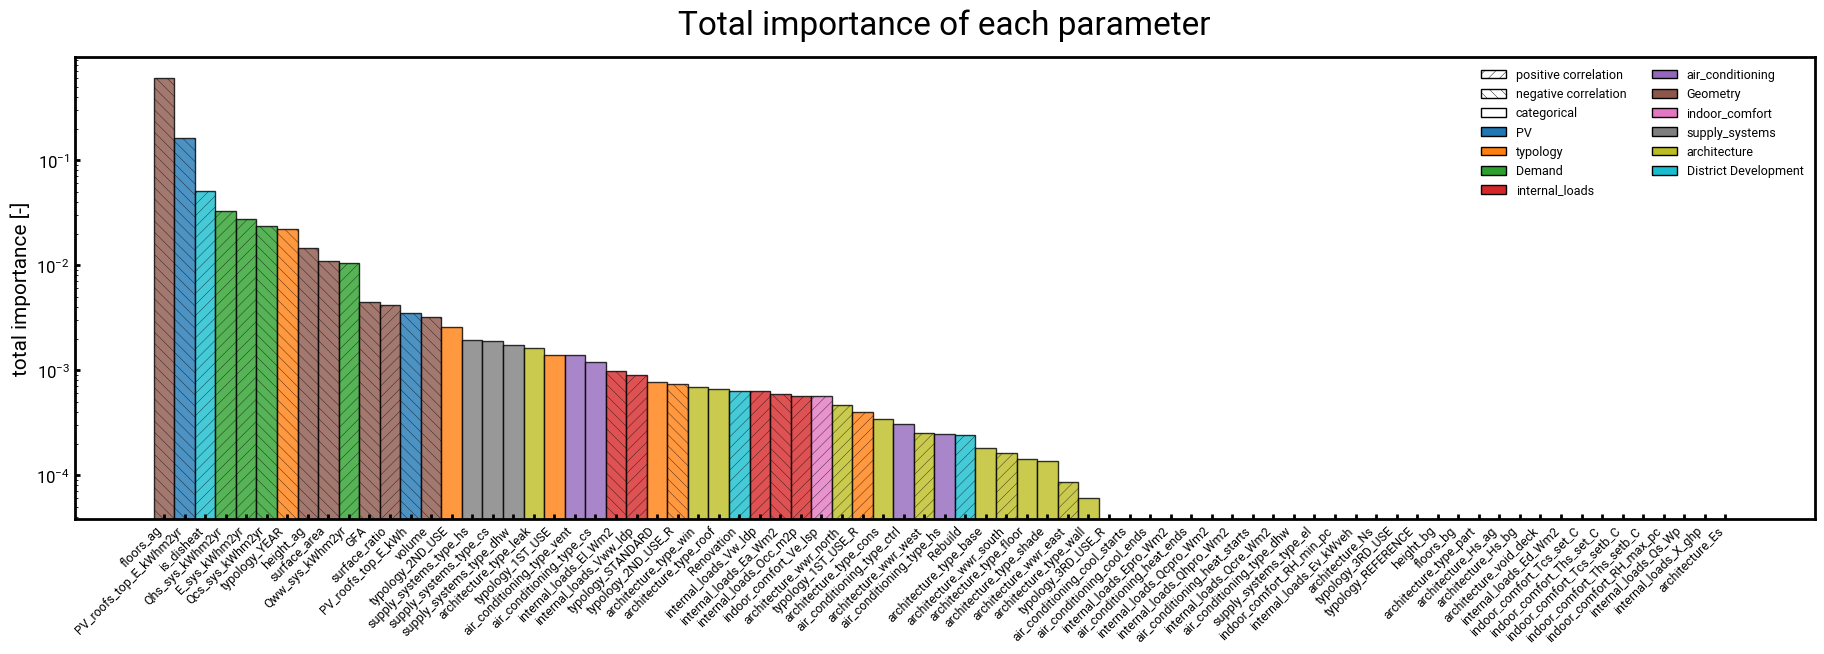

In [16]:
# then create a color dictionary to map the file to a random color
dict_file_color = {}
ls_color_palette = plt.cm.tab10.colors
for file in set(dict_feature_file.values()):
    # then, create a dictionary to map the file to the color
    dict_file_color[file] = ls_color_palette[
        list(set(dict_feature_file.values())).index(file)
    ]


# then, create a list of colors based on the feature
ls_color = [
    dict_file_color[dict_feature_file[feature]]
    for feature in total_importance_regression_df["category"]
]
# find unique numbers of files that features are coming from
ls_unique_file = list(set(dict_feature_file.values()))
plt.figure(figsize=(20, 6))
plt.bar(
    total_importance_regression_df["category"],
    total_importance_regression_df["total_importance"],
    edgecolor="black",  # add hatch to the bar
    hatch=ls_hatch,
    color=ls_color,
    alpha=0.8,  # set the width of the bar to be 0.8
    width=1,
)
# also decrease the line width of the hatch
plt.rcParams["hatch.linewidth"] = 0.3
# set the alpha of bar color to be 0.5


plt.xticks(rotation=45, ha="right", fontsize=9)
# set y axis to be log scale
plt.yscale("log")
# set the title of the plot
plt.title("Total importance of each parameter", fontsize=24)
# set the label of y axis
plt.ylabel("total importance [-]", fontsize=15)
# set legend to explain both the hatch and color. There should be 3 types of hatch and 11 types of color, so we need to create 14 patches and 14 labels. THe first three labels are hatch with no filling color, and the last 11 labels are color with no hatch
# import the required lib
import matplotlib.patches as mpatches

# create the patches and labels
ls_patch = [
    mpatches.Patch(
        facecolor="white", edgecolor="black", hatch="///", label="positive correlation"
    ),
    mpatches.Patch(
        facecolor="white",
        edgecolor="black",
        hatch="\\\\\\",
        label="negative correlation",
    ),
    mpatches.Patch(facecolor="white", edgecolor="black", hatch="", label="categorical"),
]
ls_patch += [
    mpatches.Patch(facecolor=dict_file_color[file], edgecolor="black", label=file)
    for file in ls_unique_file
]
# then, plot the legend
plt.legend(handles=ls_patch, loc="upper right", fontsize=9, ncol=2)
# save the plot
# plt.savefig(r'C:\Users\wangy\polybox - Yiqiao Wang (yiqwang@student.ethz.ch)@polybox.ethz.ch\Final Report\Graphics\total_importance_of_each_category.pdf', bbox_inches='tight')
plt.show()

In [23]:
# since some of the parameters are interrelated, we need to find out which parameters are interrelated and keep only the most important ones
# this will need knowledge of graph theory. We will use networkx to find out the most important parameters
# the function of networkx is to find out the most important nodes in a graph, and we will use the feature importance as the weight of the nodes; the edges are the correlation between the parameters
# first, we need to find out the correlation between the parameters
# we will use the correlation matrix to find out the correlation between the parameters
# before that, we need to convert the categorical columns to numerical columns and normalize the numerical columns
# we can use the previous pipeline to do that
X_transformed = pipeline_regression.named_steps["preprocessor"].transform(X)
# then generate the correlation matrix
corr_matrix = pd.DataFrame(X_transformed).corr()
# assign column names and index to the correlation matrix
corr_matrix.columns = list(numerical_columns) + list(one_hot_columns_regression)
corr_matrix.index = list(numerical_columns) + list(one_hot_columns_regression)
# now we have the correlation matrix, we can use it to generate a graph, where the nodes are the parameters, and the edges are the correlation between the parameters.
# If the correlation is larger than 0.8, we will add an edge between the two nodes
# we need to have an interactive network graph, so we will use networkx and plotly to do that
# first, import networkx
import networkx as nx

# then, create a graph
G = nx.Graph()
# then, add nodes to the graph
G.add_nodes_from(list(numerical_columns) + list(one_hot_columns_regression))
# then, add edges to the graph
for i in range(len(corr_matrix)):
    for j in range(i + 1, len(corr_matrix)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            G.add_edge(
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                weight=corr_matrix.iloc[i, j],
            )

findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not

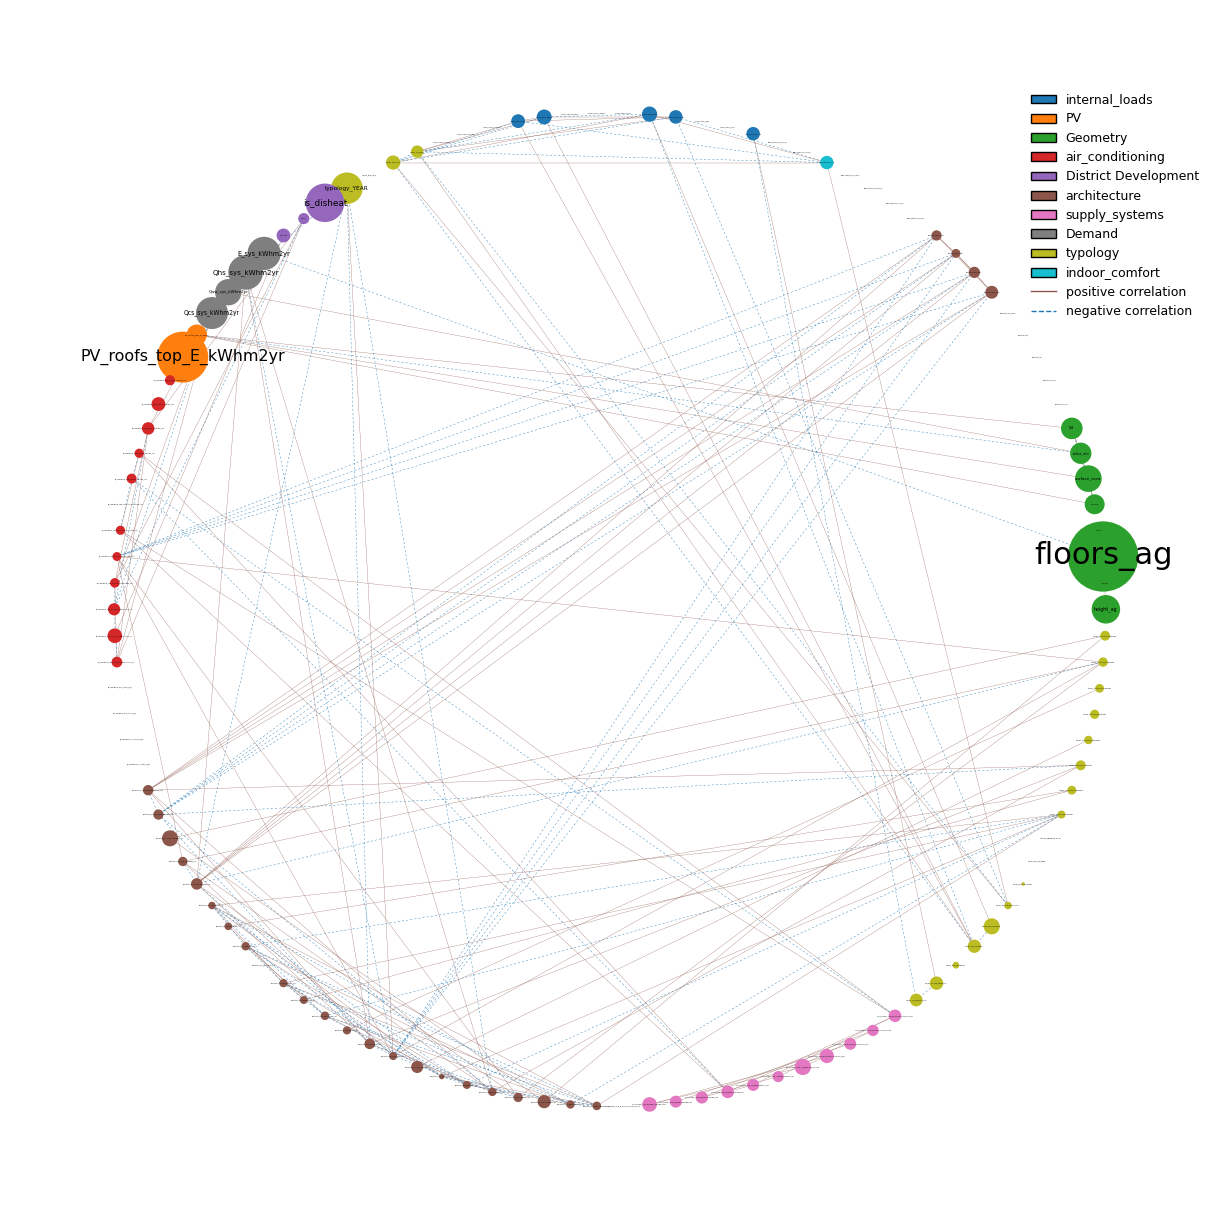

In [28]:
# then visualize the graph using plotly
# first, get the position of each node, fix 'floors_ag' and give it a position
# pos = nx.spring_layout(G, fixed=['floors_ag'], pos={'floors_ag': [0, 0]}, iterations=50, k=10)
pos = nx.circular_layout(G, dim=2)
# now don't use plotly, just use matplotlib
# set the size of node to be the importance of the feature
node_size = [
    math.sqrt(
        feature_importance_regression_df[
            feature_importance_regression_df["feature"] == node
        ]["importance"].values[0]
        * 10000000
    )
    for node in G.nodes()
]
# set the color of node to be the color of the category
# however this time we are dealing feature importance, so we need to use the feature importance dataframe, and we need to re-assign colors to the nodes based on their names
# first, get the color of each node
dict_feature_file_for_graph = {}
for node in G.nodes():
    if node in list(zone_gdf.columns):
        dict_feature_file_for_graph[node] = "Geometry"
    elif node in list(demand_df.columns):
        dict_feature_file_for_graph[node] = "Demand"
    elif node in list(supply_df.columns):
        dict_feature_file_for_graph[node] = "PV"
    elif node in list(district_df.columns) + list(rebuild_df.columns) + list(
        renovate_df.columns
    ):
        dict_feature_file_for_graph[node] = "District Development"
    # if feature is called area, length, volume, surface_area, surface_ratio, GFA, then it's called Geometry in the zone_df
    elif node in ["area", "length", "volume", "surface_area", "surface_ratio", "GFA"]:
        dict_feature_file_for_graph[node] = "Geometry"
    else:  # if the feature is not in any of the above, then it's from dbf_files, note that dbf_files is a list and we need to loop through it. Also the features contain names of the dbf files, so we need to check if feature name starts with the dbf file name
        for dbf_file in dbf_files_only:
            if node.startswith(dbf_file[:-4]):
                dict_feature_file_for_graph[node] = dbf_file[:-4]
                break
# then, create a color dictionary to map the file to a random color
dict_file_color_for_graph = {}
for file in set(dict_feature_file_for_graph.values()):
    # then, create a dictionary to map the file to the color
    dict_file_color_for_graph[file] = ls_color_palette[
        list(set(dict_feature_file_for_graph.values())).index(file)
    ]
# then, create a list of colors based on the feature
ls_color_for_graph = [
    dict_file_color_for_graph[dict_feature_file_for_graph[node]] for node in G.nodes()
]
# generate the graph
plt.figure(figsize=(12, 12))
nx.draw(
    G,
    pos,
    node_size=node_size,
    node_color=ls_color_for_graph,
    edge_color="white",
    width=0.2,
)
# then, add the labels to the graph, with size of label to be the importance of the feature. However size doesn't allow multiple inputs, so we need to use nx.draw_networkx_labels for each node with a for loop
for node in G.nodes():
    nx.draw_networkx_labels(
        G,
        pos,
        labels={node: node},
        font_size=int(
            round(
                math.sqrt(
                    feature_importance_regression_df[
                        feature_importance_regression_df["feature"] == node
                    ]["importance"].values[0]
                    * 800
                )
            )
        ),
    )

# if coefficient is positive, use solid line, otherwise dashed line
for edge in G.edges():
    if corr_matrix.loc[edge[0], edge[1]] > 0:
        nx.draw_networkx_edges(
            G, pos, edgelist=[edge], width=0.2, edge_color="tab:brown", style="solid"
        )
    else:
        nx.draw_networkx_edges(
            G, pos, edgelist=[edge], width=0.3, edge_color="tab:blue", style=(0, (5, 5))
        )
# nx.draw_networkx_edges(G, pos, width=0.1, edge_color='grey', alpha=0.5, )
# generate legend to show the color of each category using circles
# first, get the unique categories
ls_unique_category = list(set(dict_feature_file_for_graph.values()))
# then, create a list of patches
ls_patch = [
    mpatches.Patch(
        facecolor=dict_file_color_for_graph[category], edgecolor="black", label=category
    )
    for category in ls_unique_category
]
# also add the edge for the positive and negative edge colors
from matplotlib.lines import Line2D

ls_patch += [
    Line2D(
        [0],
        [0],
        color="tab:brown",
        lw=1,
        linestyle="solid",
        label="positive correlation",
    ),
    Line2D(
        [0],
        [0],
        color="tab:blue",
        lw=1,
        linestyle="dashed",
        label="negative correlation",
    ),
]

# then, plot the legend
plt.legend(handles=ls_patch, loc="upper right", fontsize=9, bbox_to_anchor=(1, 0.94))
# title of the graph
# tight layout
# plt.savefig(r'C:\Users\wangy\polybox - Yiqiao Wang (yiqwang@student.ethz.ch)@polybox.ethz.ch\Final Report\Graphics\feature_importance_network_graph2.pdf', bbox_inches='tight')
plt.show()

findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not

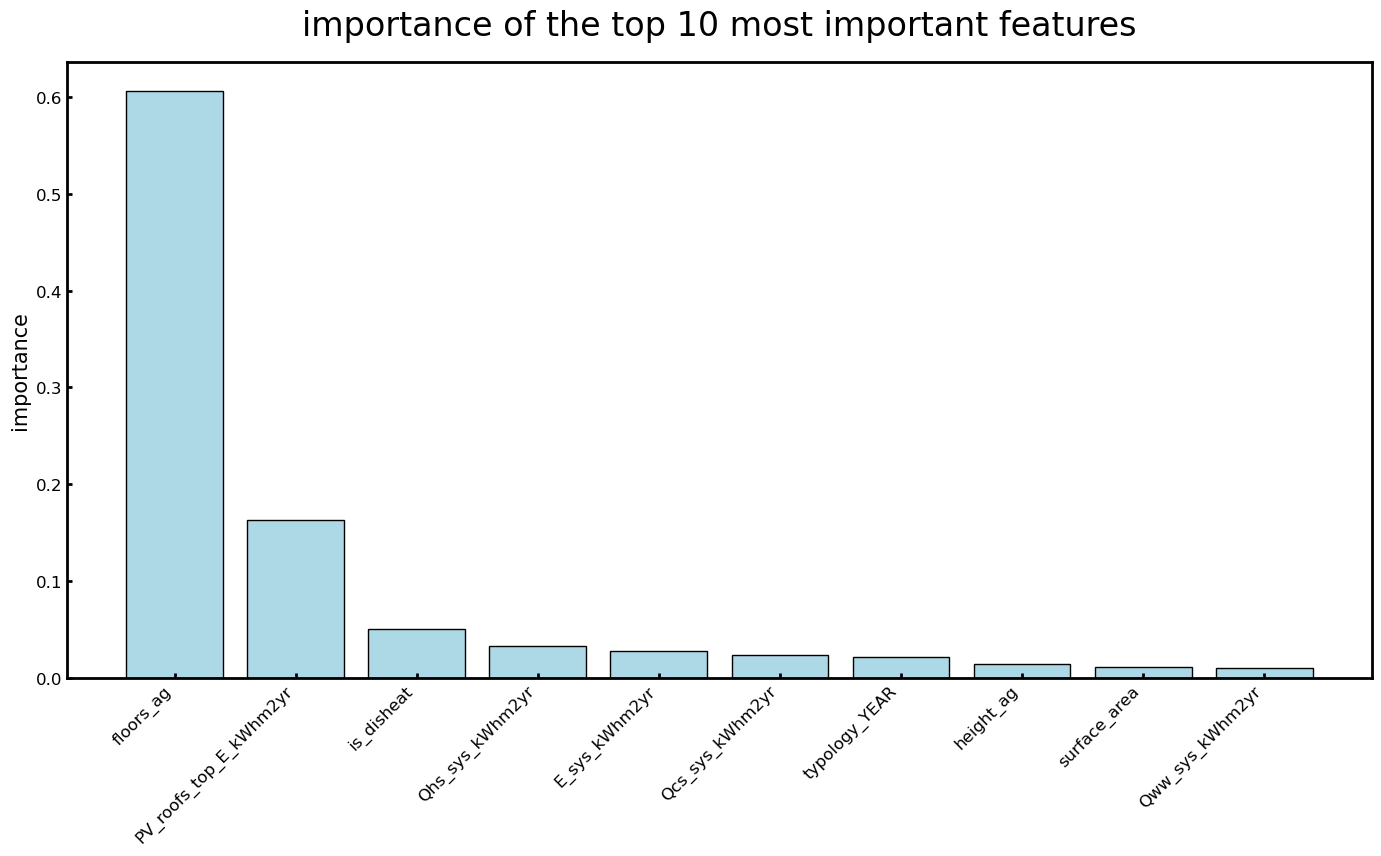

In [29]:
# plot the importance for the top 10 most important features
plt.figure(figsize=(15, 8))
# set the edge of bar to black with alpha 1.0, and the filling to be light blue with alpha 0.5
plt.bar(
    total_importance_regression_df["category"][:10],
    total_importance_regression_df["total_importance"][:10],
    edgecolor="black",
    color="lightblue",
)
plt.xticks(rotation=45, ha="right")
# set the title of the plot
plt.title("importance of the top 10 most important features", fontsize=24)
# set the label of y axis
plt.ylabel("importance", fontsize=15)
plt.show()

In [20]:
# create 6 scatter plots of the most important features, with x as the feature and y as the slope
# read the features from sorted feature importance dataframe
# create color gradient for the scatter plot based on the year of construction, which is stored in the column 'typology_YEAR'

# import required lib and prepare the color map base on the year of construction

# import colorbarbase to generate colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable

# normalize the colormap based on the year of construction
norm = colors.Normalize(vmin=X["typology_YEAR"].min(), vmax=X["typology_YEAR"].max())
# create the colormap
cmap = cm.get_cmap("viridis")

C:\Users\wangy\AppData\Local\Temp\ipykernel_17720\2612129256.py:12: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



C:\Users\wangy\AppData\Local\Temp\ipykernel_17720\788738047.py:17: UserWarning:

FixedFormatter should only be used together with FixedLocator



NameError: name 'G' is not defined

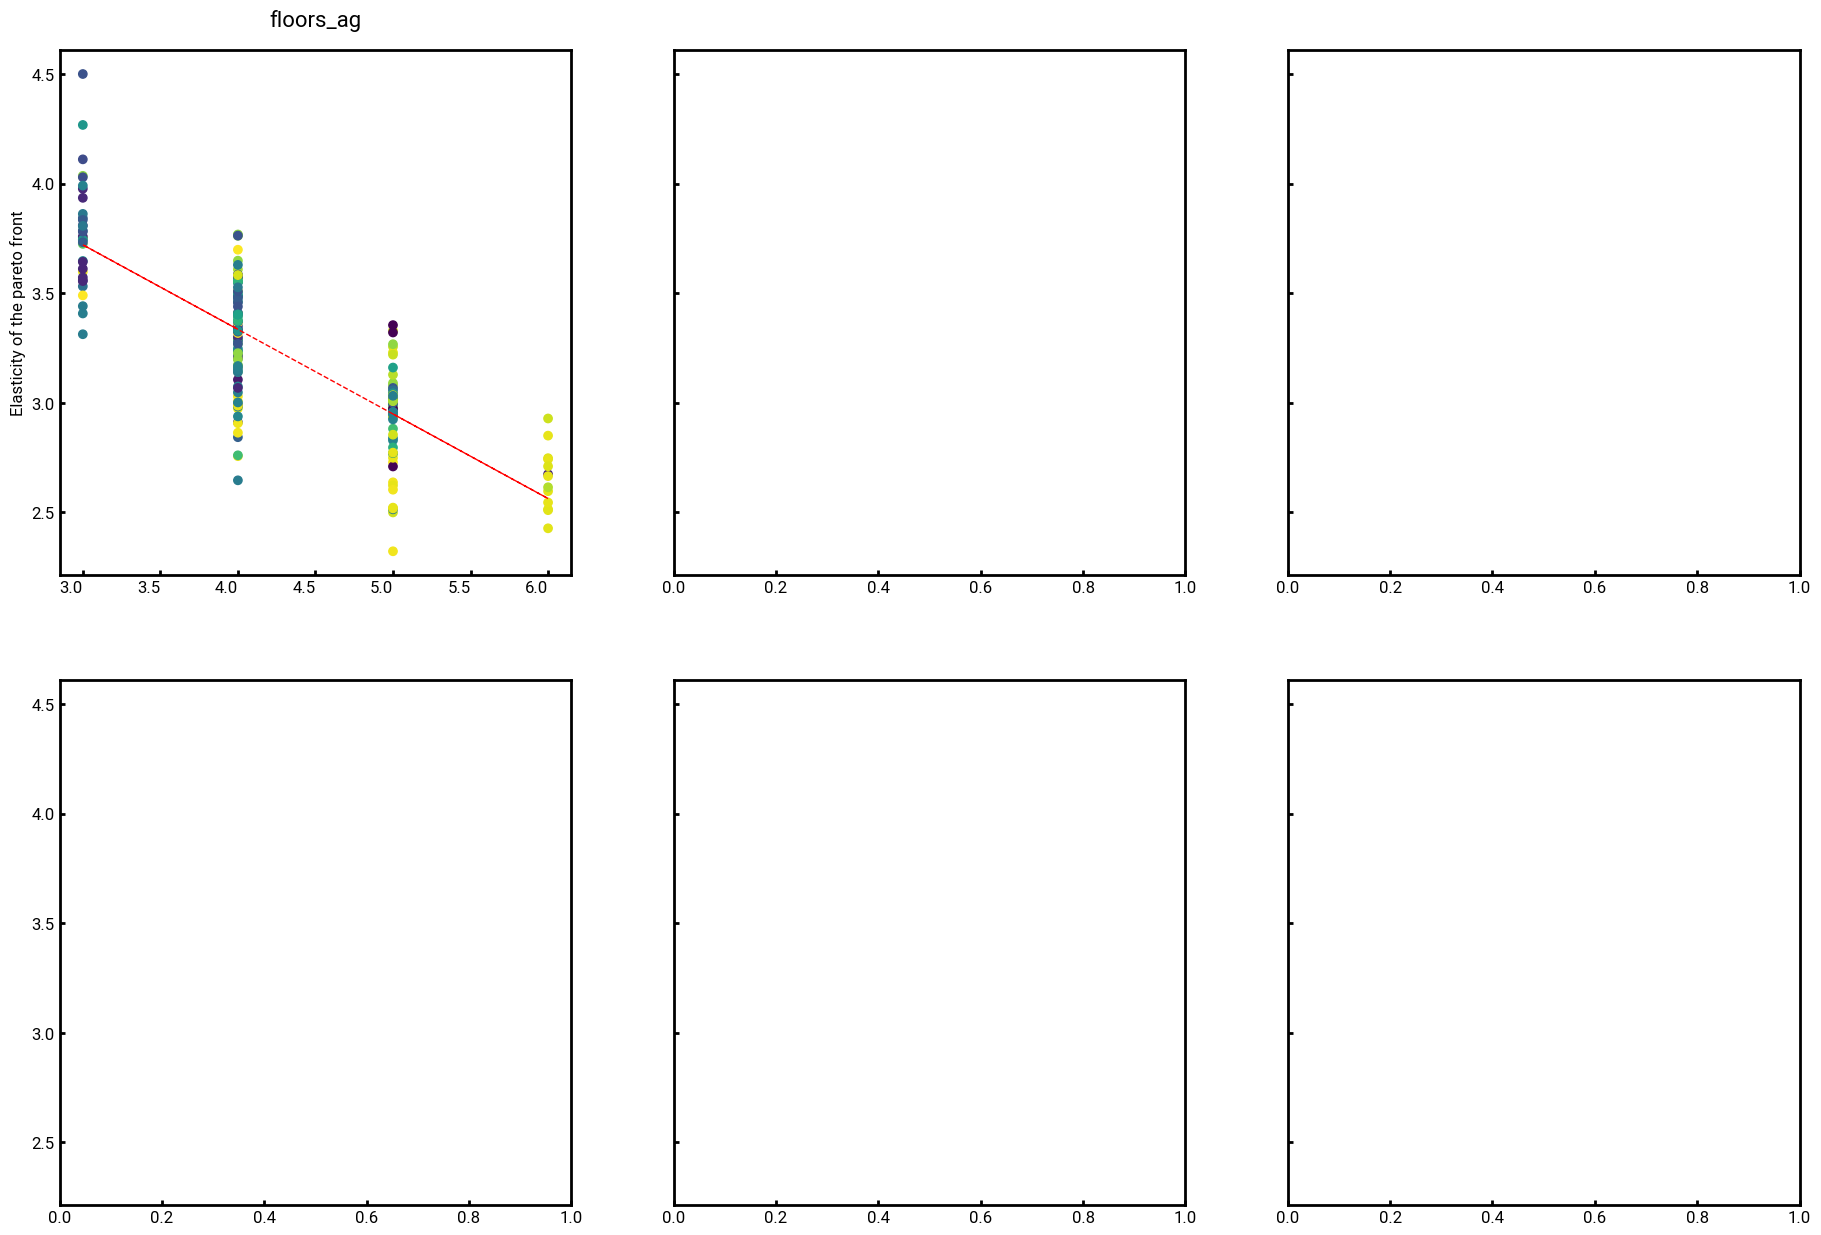

In [21]:
# create the scatter plot
# get the 10 most important features
ls_important_features = [
    "floors_ag",
    "PV_roofs_top_E_kWhm2yr",
    "Qcs_sys_kWhm2yr",
    "Qhs_sys_kWhm2yr",
    "Qww_sys_kWhm2yr",
    "E_sys_kWhm2yr",
]
# set the plot with 6 subplots and use common y axis
fig, axs = plt.subplots(2, 3, figsize=(20, 15), sharey=True)
# plot the scatter plots
for i in range(2):
    for j in range(3):
        axs[i, j].scatter(
            X[ls_important_features[i * 3 + j]], y2, c=cmap(norm(X["typology_YEAR"]))
        )
        if j == 0:
            axs[i, j].set_ylabel("Elasticity of the pareto front")
        # set the title of each subplot
        axs[i, j].set_title(ls_important_features[i * 3 + j])
        # set the x axis tick label to rotation 45 degree and right alignment. Remember, tick_params doesn't have ha so we need to use set_xticklabels
        axs[i, j].tick_params(axis="x")
        axs[i, j].set_xticklabels(axs[i, j].get_xticklabels(), ha="right")
        # plot a linear regression line
        # get the x and y values. Some of the x values are categorical,
        # we need to get the xticks and use them as x values
        x = X[ls_important_features[i * 3 + j]]
        if isinstance(
            x[0], str
        ):  # if the first value is string, then all values are string
            # then we need to find all different values of x.
            # For example, if x originally is ['a', 'b', 'a', 'c', 'b'],
            # then we need to convert it to [0, 1, 0, 2, 1]
            # first, get all different values of x
            ls_x = list(set(x))
            # then, create a dictionary to map the string to number
            dict_x = {ls_x[i]: i for i in range(len(ls_x))}
            # then, convert the x to number
            x = x.apply(lambda x: dict_x[x])
        y = y2
        # get the slope and intercept of the linear regression line
        slope, intercept = np.polyfit(x, y, 1)
        # plot the linear regression line and 95% confidence interval
        axs[i, j].plot(
            x, slope * x + intercept, color="red", linewidth=1, linestyle="dashed"
        )
        # set the text to show the importance of the feature, and first five connected features in the graph; if no more than 5 connected features, then show all connected features
        importance = feature_importance_regression_df[
            feature_importance_regression_df["feature"] == ls_important_features[i]
        ]["importance"].values[0]
        # then, get the connected features
        ls_connected_features = list(G.neighbors(ls_important_features[i]))
        # then, get the importance of the connected features
        ls_connected_features_importance = [
            feature_importance_regression_df[
                feature_importance_regression_df["feature"] == feature
            ]["importance"].values[0]
            for feature in ls_connected_features
        ]
        # then, sort the connected features based on the importance
        ls_connected_features_sorted = [
            x
            for _, x in sorted(
                zip(ls_connected_features_importance, ls_connected_features),
                reverse=True,
            )
        ]
        # then, get the first five connected features
        ls_connected_features_sorted = ls_connected_features_sorted[:5]
        # then, set the text, with multiple lines showing the importance of the feature, and first five connected features in the graph
        axs[i, j].text(
            0.98,
            0.99,
            "importance: {:.2f}\nconnected features:\n{}".format(
                importance, "\n".join(ls_connected_features_sorted)
            ),
            horizontalalignment="right",
            verticalalignment="top",
            transform=axs[i, j].transAxes,
            fontsize=6,
        )
        # # set label of each point to be the name of the building
        # for k in range(len(x)):
        #     axs[i, j].text(x[k], y[k], X.index[k], fontsize=6)

# generate a colorbar on the right side of the whole plot
cax = plt.axes((0.96, 0.11, 0.02, 0.77))
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
cbar.set_label("year of construction")
# set the two rows a bit further apart
plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(wspace=0.05)
# set the title of the whole plot
plt.suptitle("scatter plot of the 6 most important features", y=0.95, fontsize=30)

# plt.savefig(r'C:\Users\wangy\polybox - Yiqiao Wang (yiqwang@student.ethz.ch)@polybox.ethz.ch\Final Report\Graphics\scatter_plot_6_most_important_features.pdf', bbox_inches='tight')
plt.show()

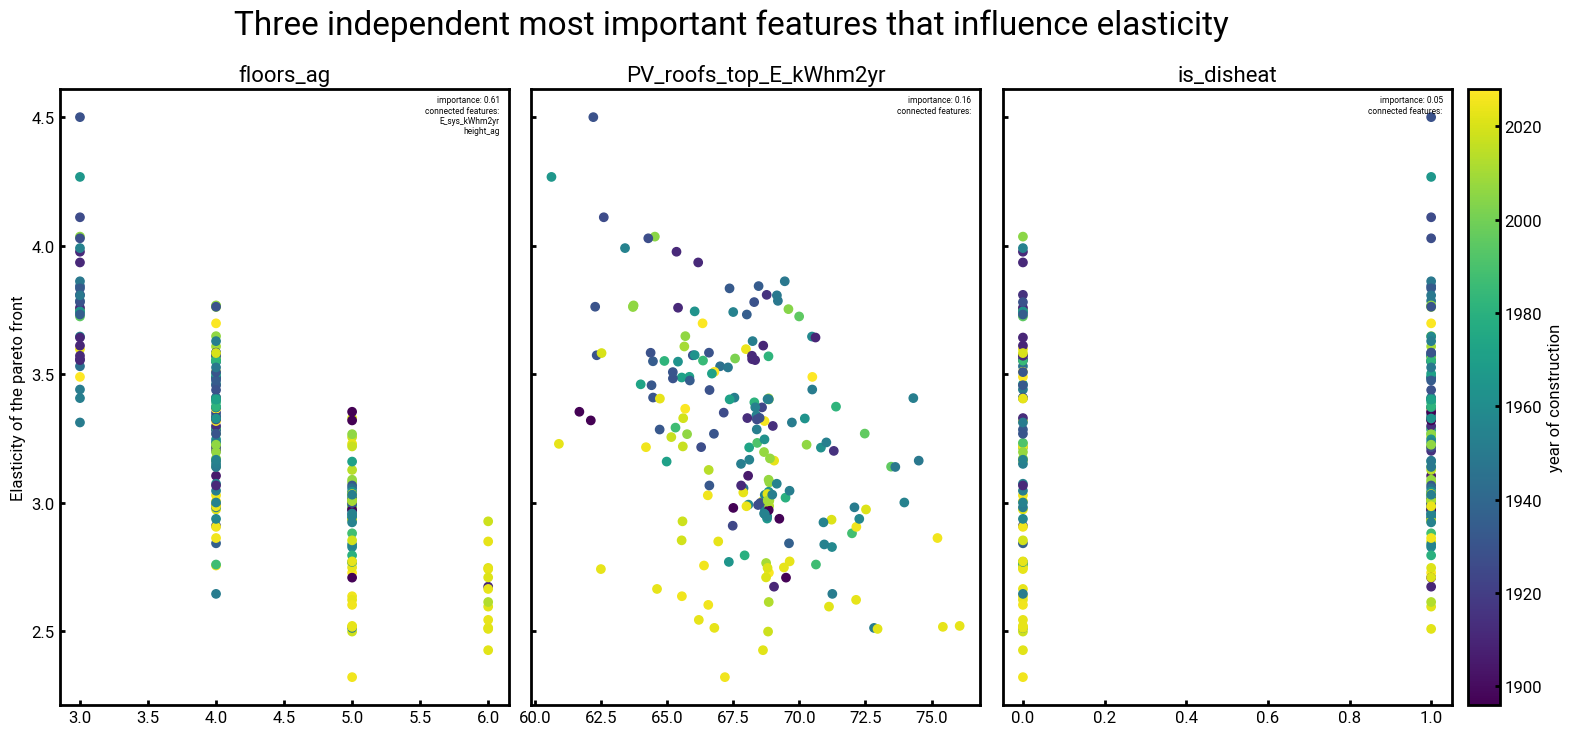

In [24]:
# Do the same plot, but only with floors_ag, surface_ratio, height_ag and typology_STANDARD
# create the scatter plot
# get the 10 most important features
ls_wanted_features = ["floors_ag", "PV_roofs_top_E_kWhm2yr", "is_disheat"]
# set the plot with 4 subplots and use common y axis
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 8))
# plot the scatter plots
for i in range(3):
    axs[i].scatter(X[ls_wanted_features[i]], y2, c=cmap(norm(X["typology_YEAR"])))
    if i == 0:
        axs[i].set_ylabel("Elasticity of the pareto front")
    # set the title of each subplot
    axs[i].set_title(ls_wanted_features[i], y=1)
    if ls_wanted_features[i] == "E_sys_kWhm2yr":
        axs[i].set_xlim(21, 29)
    # set the x axis tick label to rotation 45 degree and right alignment. Remember, tick_params doesn't have ha so we need to use set_xticklabels
    # axs[i].tick_params(axis='x', rotation=45)
    # axs[i].set_xticklabels(axs[i].get_xticklabels(), ha='right')
    # plot a linear regression line
    # get the x and y values. Some of the x values are categorical,
    # we need to get the xticks and use them as x values
    x = X[ls_wanted_features[i]]
    if isinstance(
        x[0], str
    ):  # if the first value is string, then all values are string
        # then we need to find all different values of x.
        # For example, if x originally is ['a', 'b', 'a', 'c', 'b'],
        # then we need to convert it to [0, 1, 0, 2, 1]
        # first, get all different values of x
        ls_x = list(set(x))
        # then, create a dictionary to map the string to number
        dict_x = {ls_x[i]: i for i in range(len(ls_x))}
        # then, convert the x to number
        x = x.apply(lambda x: dict_x[x])
    y = y2
    # get the slope and intercept of the linear regression line
    # then, set the text to show the importance of the feature, and first five connected features in the graph; if no more than 5 connected features, then show all connected features
    # first, get the importance of the feature
    importance = feature_importance_regression_df[
        feature_importance_regression_df["feature"] == ls_wanted_features[i]
    ]["importance"].values[0]
    # then, get the connected features
    ls_connected_features = list(G.neighbors(ls_wanted_features[i]))
    # then, get the importance of the connected features
    ls_connected_features_importance = [
        feature_importance_regression_df[
            feature_importance_regression_df["feature"] == feature
        ]["importance"].values[0]
        for feature in ls_connected_features
    ]
    # then, sort the connected features based on the importance
    ls_connected_features_sorted = [
        x
        for _, x in sorted(
            zip(ls_connected_features_importance, ls_connected_features), reverse=True
        )
    ]
    # then, get the first five connected features
    ls_connected_features_sorted = ls_connected_features_sorted[:5]
    # then, set the text, with multiple lines showing the importance of the feature, and first five connected features in the graph
    axs[i].text(
        0.98,
        0.99,
        "importance: {:.2f}\nconnected features:\n{}".format(
            importance, "\n".join(ls_connected_features_sorted)
        ),
        horizontalalignment="right",
        verticalalignment="top",
        transform=axs[i].transAxes,
        fontsize=6,
    )


# generate a colorbar on the right side of the whole plot
cax = plt.axes((0.96, 0.11, 0.02, 0.77))
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
cbar.set_label("year of construction")
# set the two rows a bit further apart
# plt.subplots_adjust(hspace=0.3)
# set the tow columns a bit closer
plt.subplots_adjust(wspace=0.05)
# set the title of the whole plot
plt.suptitle(
    "Three independent most important features that influence elasticity", fontsize=24
)
# make sure the plot is tight

# plt.savefig(r'C:\Users\wangy\polybox - Yiqiao Wang (yiqwang@student.ethz.ch)@polybox.ethz.ch\Final Report\Graphics\scatter_plot_3_most_important_features.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# create the scatter plot
# get the 10 most important features
ls_wanted_features = [
    "PV_roofs_top_E_kWhm2yr",
    "floors_ag",
    "Qcs_sys_kWhm2yr",
    "surface_ratio",
]

findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not

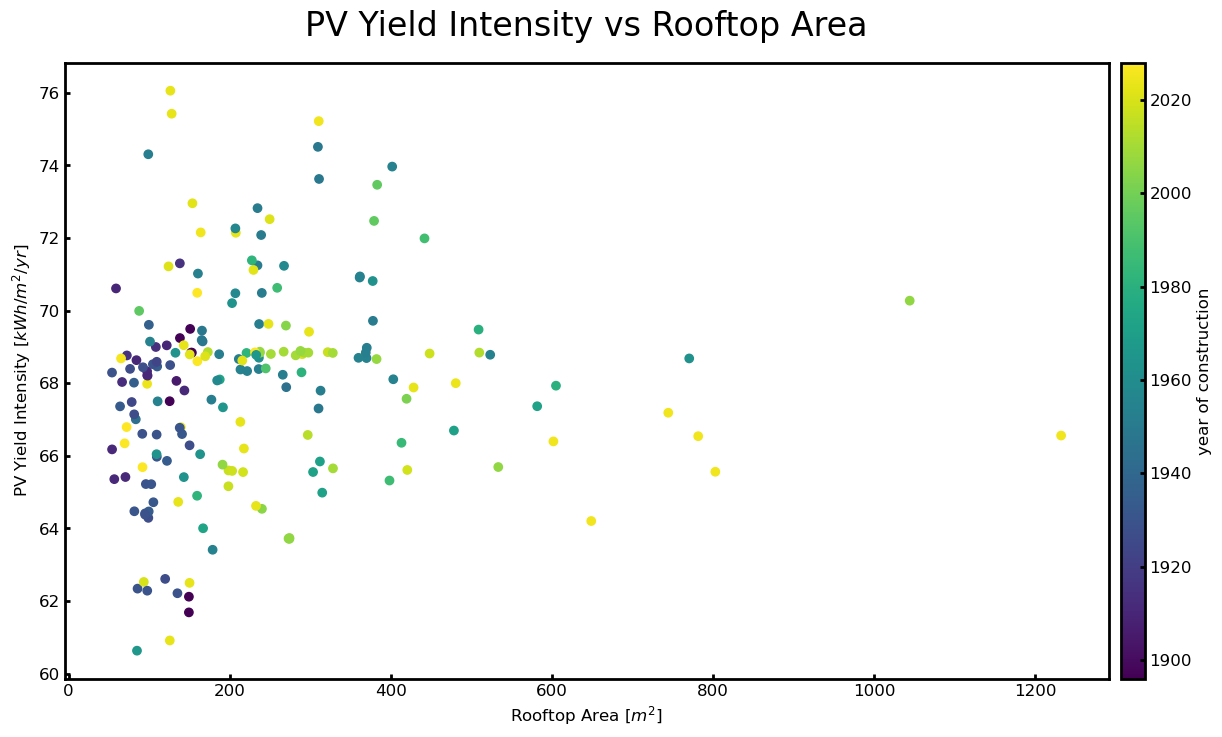

In [35]:
# plot the relationship of number of floors and heating demand instensity
plt.figure(figsize=(12, 8))
plt.scatter(
    zone_df["GFA"] / zone_df["floors_ag"],
    zone_df["PV_roofs_top_E_kWhm2yr"],
    c=cmap(norm(zone_df["typology_YEAR"])),
)
plt.xlabel("Rooftop Area $[m^2]$")
plt.ylabel("PV Yield Intensity $[kWh/m^2/yr]$")
plt.title("PV Yield Intensity vs Rooftop Area", fontsize=24)
cax = plt.axes((0.96, 0.11, 0.02, 0.77))
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
cbar.set_label("year of construction")
# plt.savefig(r'C:\Users\wangy\polybox - Yiqiao Wang (yiqwang@student.ethz.ch)@polybox.ethz.ch\Final Report\Graphics\scatter_plot_rooftop_area_pv_yield_intensity.pdf', bbox_inches='tight')
plt.show()